# Simulation Run Log Analysis and Visualization for AWS DeepRacer

This notebook walks through how you can analyze and debug using the AWS DeepRacer Simulation logs 


1. Tools to find best iteration of your model
1. Visualize reward distribution on the track
 - Visualize reward heatmap per episode or iteration
1. Identify hotspots on the track for your model
1. Understand probability distributions on simulated images
1. Evaluation run analysis - plot lap speed heatmap


## Requirements

boto3 >= 1.9.133  ; configure your aws cli and/or boto credentials file

AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html

Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

## IAM permissions


Assign your Sagemaker notebook an execution role with permission to access the deepracer service. Typically this is done by providing "deepracer:*" permissions.

In [13]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import boto3
import shutil
import os
import glob
import math
import tarfile
import requests
import json
%matplotlib inline

In [2]:
#Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

In [14]:
from log_analysis import *
from os import listdir
from os.path import isfile, join


## Jobs run from AWS DeepRacer Console. Download the desired log file by providing model name

In [15]:
model_name="September-GridAI/" ## Change to your model
is_training = False  ## Make this False if you want to do log analysis on Evaluation.


In [16]:
!rm -rf ./tmp
!rm -rf ./intermediate_checkpoint
!rm -rf ./downloaded_model

In [18]:
envroot = os.getcwd()
aws_data_path = set(os.environ.get('AWS_DATA_PATH', '').split(os.pathsep))
aws_data_path.add(os.path.join(envroot, 'models'))
os.environ.update({'AWS_DATA_PATH': os.pathsep.join(aws_data_path)})

region = "us-east-1"
dr_client = boto3.client('deepracer', region_name=region,
        endpoint_url="https://deepracer-prod.{}.amazonaws.com".format(region))
models = dr_client.list_models(ModelType="REINFORCEMENT_LEARNING",MaxResults=100)["Models"]
for model in models:
    if model["ModelName"]==model_name:
        break
ModelArn=model["ModelArn"]

In [19]:

def download_log_file(url, model_name):
    directory = os.path.dirname(model_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    with requests.get(url, stream=True) as response:
        with open("{}.tar.gz".format(model_name), "wb") as tarball:
            for chunk in response.iter_content(16384):
                tarball.write(chunk)

if is_training:
    training_jobs = dr_client.list_training_jobs(ModelArn=ModelArn, MaxResults=100)["TrainingJobs"]
    if training_jobs:
        training_job = training_jobs[0]
        training_log_url = dr_client.get_asset_url(Arn=training_job['JobArn'], AssetType="LOGS")['Url']
        download_log_file(training_log_url, model_name)
    else:
        print("No training jobs found.")
else:
    evaluation_jobs = dr_client.list_evaluations(ModelArn=ModelArn, MaxResults=100)["EvaluationJobs"]
    if evaluation_jobs:
        print(evaluation_jobs)
        evaluation_job = evaluation_jobs[0]
        evaluation_log_url = dr_client.get_asset_url(Arn=evaluation_job['JobArn'], AssetType="LOGS")['Url']
        download_log_file(evaluation_log_url, model_name)
    else:
        print("No evaluation jobs found.")

[{'JobArn': 'arn:aws:deepracer:us-east-1:905418423139:evaluation_job/vy3EFJiQRBCzj5WO-vkcng', 'ActivityJob': {'ModelArn': 'arn:aws:deepracer:us-east-1:905418423139:model/reinforcement_learning/5ee2d371-f26a-4cb5-8a82-9a43997088e7', 'CreationTime': 1727269218666, 'StartTime': 1727269544090, 'EndTime': 1727270012377, 'Status': {'JobStatus': 'COMPLETED'}, 'MetricsS3Path': 's3://aws-deepracer-data-us-east-1-1/data-ba3893c6-f65f-45bc-a39c-fa51f1f5e620/models/5ee2d371-f26a-4cb5-8a82-9a43997088e7/metrics/evaluation/evaluation-20240925130038-vy3EFJiQRBCzj5WO-vkcng.json', 'MetricsPreSignedUrl': 'https://aws-deepracer-data-us-east-1-1.s3.amazonaws.com/data-ba3893c6-f65f-45bc-a39c-fa51f1f5e620/models/5ee2d371-f26a-4cb5-8a82-9a43997088e7/metrics/evaluation/evaluation-20240925130038-vy3EFJiQRBCzj5WO-vkcng.json?X-Amz-Security-Token=IQoJb3JpZ2luX2VjELb%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLWVhc3QtMSJHMEUCIEY50tStoy6f%2BAfAVMOTDpdX9WEEafms59PHHZO%2Bn1D6AiEAvomd0q1onMmBGzcpH2vbOKKU05ScJbFLinGbRLNZ%2B%2F

In [42]:
ModelUuid=ModelArn[ModelArn.rfind('/')+1:]
simtrace_path = "./downloaded_model/{}/sim-trace/training/training-simtrace/".format(ModelUuid)
if not is_training:
    simtrace_path = "./downloaded_model/{}/sim-trace/evaluation/*/evaluation-simtrace/".format(ModelUuid)
merged_simtrace_path = "./logs/deepracer-{}.csv".format(model_name)

In [43]:
!mkdir -p downloaded_model/{ModelUuid}
!mkdir -p intermediate_checkpoint/{ModelUuid}/model-artifacts

!tar -xf {model_name}.tar.gz -C ./downloaded_model/
!mkdir -p ./tmp
!rsync -a --delete --include=*.csv --exclude=* {simtrace_path} ./tmp/
!rm -rf downloaded_model/{model_name}
!rm -rf {model_name}.tar.gz

tar: September-GridAI/.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [44]:
model_url = dr_client.get_asset_url(Arn=model["ModelArn"], AssetType="COMPLETE_MODEL_ARTIFACT")['Url']

with requests.get(model_url, stream=True) as response:
    with open("{}-model.tar.gz".format(model_name), "wb") as tarball:
        for chunk in response.iter_content(16384):
            tarball.write(chunk)

!tar --wildcards -zxvf {model_name}-model.tar.gz -C intermediate_checkpoint/ '*.csv' '{ModelUuid}/model/*' '{ModelUuid}/metrics/*'
!rm -rf {model_name}-model.tar.gz

5ee2d371-f26a-4cb5-8a82-9a43997088e7/metrics/evaluation/evaluation-20240925130038-vy3EFJiQRBCzj5WO-vkcng.json
5ee2d371-f26a-4cb5-8a82-9a43997088e7/metrics/training/training-20240922072323-usuPc3IWRhOzBIJGOznZkw.json
5ee2d371-f26a-4cb5-8a82-9a43997088e7/model/9_Step-6077.ckpt.data-00000-of-00001
5ee2d371-f26a-4cb5-8a82-9a43997088e7/model/9_Step-6077.ckpt.index
5ee2d371-f26a-4cb5-8a82-9a43997088e7/model/9_Step-6077.ckpt.meta
5ee2d371-f26a-4cb5-8a82-9a43997088e7/model/model_38.pb
5ee2d371-f26a-4cb5-8a82-9a43997088e7/model/model_39.pb
5ee2d371-f26a-4cb5-8a82-9a43997088e7/model/model_40.pb
5ee2d371-f26a-4cb5-8a82-9a43997088e7/model/model_9.pb
5ee2d371-f26a-4cb5-8a82-9a43997088e7/model/model_metadata.json
5ee2d371-f26a-4cb5-8a82-9a43997088e7/sim-trace/evaluation/20240925130038-vy3EFJiQRBCzj5WO-vkcng/evaluation-simtrace/0-iteration.csv
5ee2d371-f26a-4cb5-8a82-9a43997088e7/sim-trace/training/training-simtrace/0-iteration.csv
5ee2d371-f26a-4cb5-8a82-9a43997088e7/sim-trace/training/training-simt

In [46]:
model_url = dr_client.get_asset_url(Arn=model["ModelArn"], AssetType="MODEL_ARTIFACT")['Url']

with requests.get(model_url, stream=True) as response:
    with open("{}-model-artifacts.tar.gz".format(model_name), "wb") as tarball:
        for chunk in response.iter_content(16384):
            tarball.write(chunk)

!tar --warning=no-unknown-keyword -zxvf {model_name}-model-artifacts.tar.gz -C intermediate_checkpoint/{ModelUuid}/model-artifacts
!rm -rf {model_name}-model-artifacts.tar.gz

worker_0.multi_agent_graph.main_level.main_level.agent_0.csv
model_metadata.json
agent/
agent/model.pb
worker_0.multi_agent_graph_0.json


In [47]:
with open("intermediate_checkpoint/{}/model/model_metadata.json".format(ModelUuid),"r") as jsonin:
    model_metadata=json.load(jsonin)
sensor = [sensor for sensor in model_metadata['sensor'] if sensor != "LIDAR"][0]
model_metadata

{'action_space': {'steering_angle': {'high': 30.0, 'low': -30.0},
  'speed': {'high': 4.0, 'low': 1.0}},
 'sensor': ['SECTOR_LIDAR', 'STEREO_CAMERAS'],
 'neural_network': 'DEEP_CONVOLUTIONAL_NETWORK_SHALLOW',
 'version': '5',
 'training_algorithm': 'clipped_ppo',
 'action_space_type': 'continuous',
 'preprocess_type': 'GREY_SCALE',
 'regional_parameters': [0, 0, 0, 0]}

In [49]:
def get_sort_csv_file():
    sim_trace_csvs = glob.glob("./tmp/*.csv")
    csvs_with_ids = [(int(os.path.basename(file).split("-")[0]), file) for file in sim_trace_csvs]
    csvs_sorted = sorted(csvs_with_ids, key=lambda csvs_with_ids: csvs_with_ids[0])
    return [csv_file[1] for csv_file in csvs_sorted]
    
def merge_csv_files(output_file_path):
    csv_files = get_sort_csv_file()
    header_saved = False
    with open(output_file_path, 'w') as fout:
        for csv_file in csv_files:
            with open(csv_file) as fin:
                header = next(fin)
                if not header_saved:
                    fout.write(header)
                    header_saved = True
                for line in fin:
                    line = re.sub(r'(\[[^\]]*\])', r'"\1"', line, flags=re.M)
                    fout.write(line)

# Define the directory and file path
directory = './logs/deepracer-September-GridAI/'
merged_simtrace_path = os.path.join(directory, 'merged_simtrace.csv')

# Check if the directory exists, if not, create it
if not os.path.exists(directory):
    os.makedirs(directory)

    
merge_csv_files(merged_simtrace_path)
!tail -n 3 $merged_simtrace_path

2,646.0,-8.878888912956183,-1.1510837790317952,-96.4799430106505,21.724737882614136,1.0,"[21.724737882614136 1.0]",1.0,False,True,99.55951165097504,222,59.35085588912497,193.088,in_progress,0.0,0
2,647.0,-8.874847255284497,-1.3267986186014034,-91.92095143559524,8.612648248672485,1.0,"[8.612648248672485 1.0]",1.0,False,True,99.82634401052476,223,59.35085588912497,193.169,in_progress,0.0,0
2,648.0,-8.857293157183241,-1.459826228210606,-87.27351469559069,30.0,2.598507098853588,"[30.0 2.598507098853588]",0.5,True,True,100,0,59.35085588912497,193.258,lap_complete,0.0,0


#### Merge all the csv files into one big .csv file

## Load waypoints for the track you want to run analysis on


In [50]:
ListFiles = [f for f in listdir("tracks/") if isfile(join("tracks/", f))]
print(ListFiles)

['2022_august_open_cw.npy', '2022_september_open_cw.npy', '2022_march_open_ccw.npy', 'reInvent2019_track_cw.npy', 'New_York_Track.npy', 'ChampionshipCup2019_track.npy', 'reinvent_base.npy', '2022_reinvent_champ.npy', '2022_july_pro_cw.npy', 'Vegas_track.npy', 'arctic_pro_ccw.npy', '2022_may_open_ccw.npy', 'FS_June2020.npy', 'reInvent2019_wide_mirrored.npy', 'London_Loop_Train.npy', '2022_march_pro_cw.npy', 'penbay_open_cw.npy', 'Oval_track.npy', 'penbay_pro.npy', 'LGSWide.npy', '2022_june_pro_ccw.npy', 'thunder_hill_open.npy', 'Monaco_building.npy', 'Singapore_building.npy', '2022_march_pro_ccw.npy', '2022_july_pro_ccw.npy', 'reInvent2019_wide_ccw.npy', 'penbay_pro_ccw.npy', 'reInvent2019_wide.npy', 'Aragon.npy', 'hamption_pro.npy', '2022_may_pro_cw.npy', 'caecer_loop.npy', 'Austin.npy', 'arctic_open_cw.npy', 'Straight_track.npy', 'arctic_pro.npy', '2022_may_pro_ccw.npy', 'red_star_pro_ccw.npy', 'China_track.npy', 'jyllandsringen_open_ccw.npy', 'Virtual_May19_Train_track.npy', 'arctic_

In [51]:
def get_track_waypoints(track_name):
    return np.load("tracks/%s.npy" % track_name)

if is_training:
    track_arn=training_job["Config"]["TrackConfig"]["TrackArn"]
else:
    track_arn=evaluation_job["Config"]["TrackArn"]

trackname=track_arn[track_arn.rfind("/")+1:]
waypoints = get_track_waypoints(trackname)
waypoints.shape

(224, 6)

## Visualize the Track and Waypoints

In [52]:
def plot_points(ax, points):
    ax.scatter(points[:-1,0], points[:-1,1], s=1)
    for i,p in enumerate(points):
        ax.annotate(i, (p[0], p[1]))

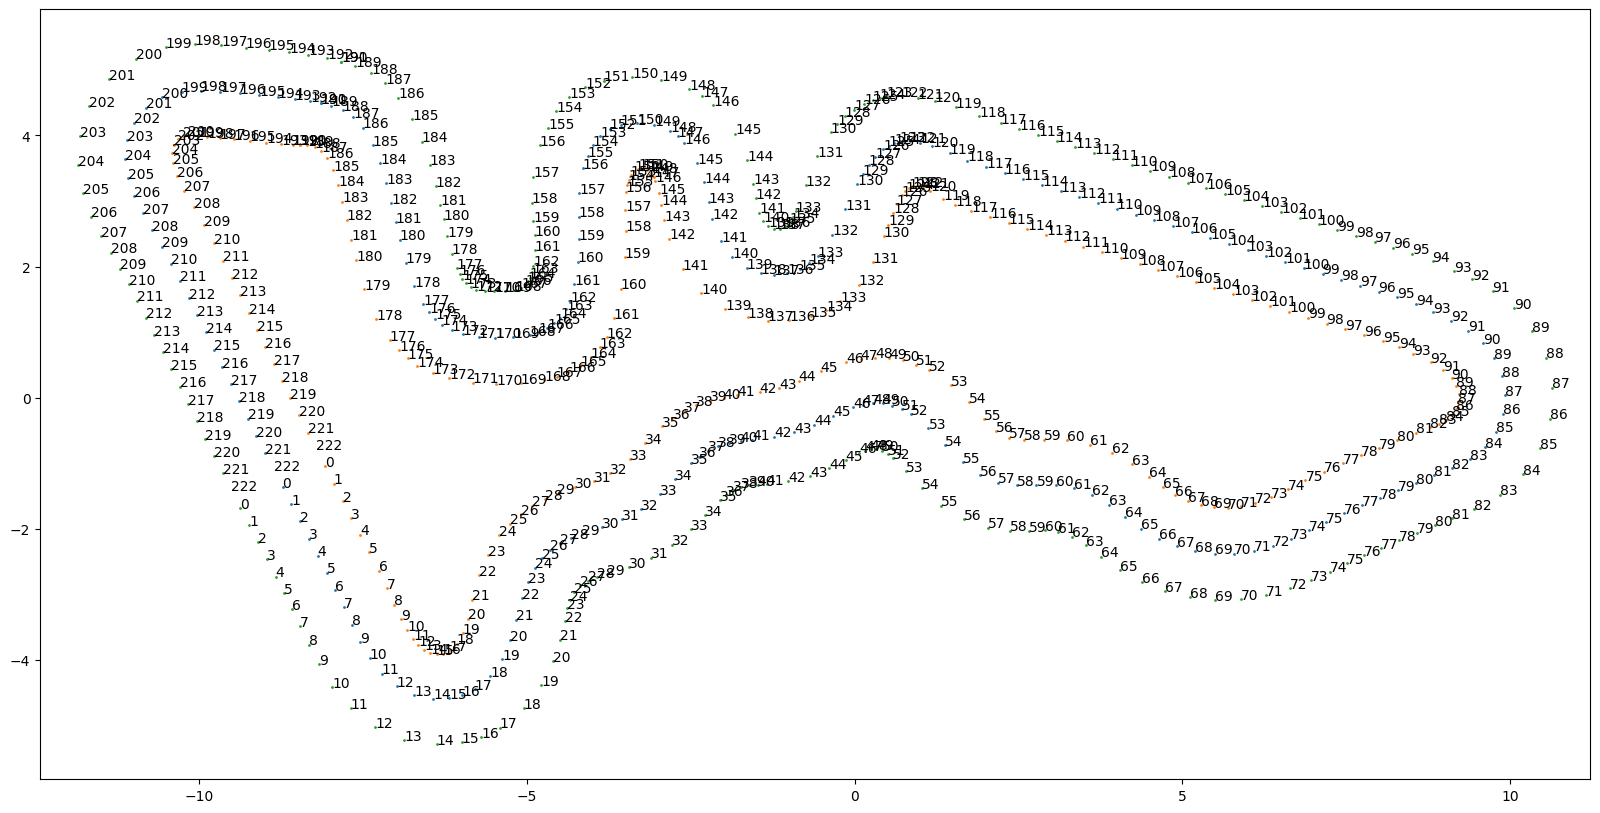

In [53]:
# Plot the results
fig, ax = plt.subplots(figsize=(20,10))
plot_points(ax, waypoints[:-1,0:2])
plot_points(ax, waypoints[:-1,2:4])
plot_points(ax, waypoints[:-1,4:6])
ax.axis('equal')
plt.show()

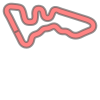

In [55]:
# Use Shapely to generate lines for the inner 
# and outer track borders, and centerline
l_center_line = LineString(waypoints[:,0:2])
l_inner_border = LineString(waypoints[:,2:4])
l_outer_border = LineString(waypoints[:,4:6])

# Create a shapely Polygon representing the track
road_poly = Polygon(np.vstack((l_outer_border.coords, np.flipud(l_inner_border.coords))))
road_poly

In [56]:
# rescale waypoints to centimeter scale

center_line = waypoints[:,0:2] 
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

# Helper Functions 

In [57]:
def plot_track(df, track_size=(500, 800), x_offset=0, y_offset=0, scale=100):
    '''
    Each track may have a diff track size, 
    For reinvent track, use track_size=(500, 800)
    Tokyo, track_size=(700, 1000)
    x_offset, y_offset is used to convert to the 0,0 coordinate system
    '''
    #track = np.zeros(track_size) # lets magnify the track by *100
    #for index, row in df.iterrows():
    #    x = int(row["x"]*scale + x_offset)
    #    y = int(row["y"]*scale + y_offset)
    #    reward = row["reward"]
    #    track[y, x] = reward
    #   plt.plot(y,x,reward)
    allx=[]
    ally=[]
    allreward=[]
    for index, row in df.iterrows():
        x = float(row["x"])
        y = float(row["y"])
        reward = float(row["reward"])
        allx.append(x)
        ally.append(y)
        allrewards=reward
        #track[y, x] = reward
        #plt.plot(y,x,reward)
    heatmap, xedges, yedges = np.histogram2d(allx, ally, bins=50)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        
    #fig = plt.figure(1, figsize=(12, 16))
    fig = plt.figure(1, figsize=track_size)
    ax = fig.add_subplot(111)
    print_border(ax, center_line, inner_border, outer_border)
    return heatmap.T,extent

In [58]:
def plot_top_laps(sorted_idx, n_laps=5):
    fig = plt.figure(n_laps, figsize=(12, 30))
    for i in range(n_laps):
        idx = sorted_idx[i]
        
        episode_data = episode_map[idx]
        
        ax = fig.add_subplot(n_laps,1,i+1)
        
        line = LineString(center_line)
        plot_coords(ax, line)
        plot_line(ax, line)
        
        line = LineString(inner_border)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(outer_border)
        plot_coords(ax, line)
        plot_line(ax, line)


        for idx in range(1, len(episode_data)-1):
            x1,y1,action,reward,angle,speed = episode_data[idx]
            car_x2, car_y2 = x1 - 0.02, y1
            plt.plot([x1, car_x2], [y1, car_y2], 'b.')
        
    return fig

## Load the training log

In [59]:
EPISODE_PER_ITER = 20 if is_training else 1

In [60]:
df = pd.read_csv(merged_simtrace_path)
iteration_arr = np.arange(math.ceil(df.episode.max()/EPISODE_PER_ITER)+1) * EPISODE_PER_ITER
df['iteration'] = np.digitize(df.episode, iteration_arr)
df = df.rename(columns={"X": "x", "Y": "y", "tstamp": "timestamp"})
df.head()

,episode,steps,x,y,yaw,steer,throttle,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,timestamp,episode_status,pause_duration,obstacle_crash_counter,iteration
0,0,1.0,-8.657269,-1.488887,-62.526816,2.482997,2.920861,[2.482996881008148 2.9208613485097885],0.0,False,True,0.236200,0,59.350856,6.271,prepare,0.0,0,1
1,0,2.0,-8.657348,-1.488718,-62.525153,2.488565,2.920871,[2.4885646998882294 2.92087122797966],1.0,False,True,0.235885,0,59.350856,6.306,in_progress,0.0,0,1
2,0,3.0,-8.656084,-1.495132,-63.015500,1.770455,3.121896,[1.7704552039504051 3.1218963116407394],1.0,False,True,0.246456,0,59.350856,6.442,in_progress,0.0,0,1
3,0,4.0,-8.631864,-1.548654,-63.559610,1.082547,3.102391,[1.0825471580028534 3.1023907512426376],1.0,False,True,0.345291,1,59.350856,6.524,in_progress,0.0,0,1
4,0,5.0,-8.598660,-1.614214,-63.478177,2.849966,2.725362,[2.849966213107109 2.725361593067646],1.0,False,True,0.469106,1,59.350856,6.619,in_progress,0.0,0,1


If the model loaded uses a continuous action space, convert it to a discrete action space for analysis. This will map the choices the model made in the simtrace logs into discrete buckets to allow for later visualization.

In [61]:
NUM_ANGLE_BUCKETS = 5
NUM_SPEED_BUCKETS = 4

if 'action_space_type' in model_metadata and model_metadata['action_space_type']=='continuous':
    max_angle = model_metadata['action_space']['steering_angle']['high']
    min_angle = model_metadata['action_space']['steering_angle']['low']

    max_speed = model_metadata['action_space']['speed']['high']
    min_speed = model_metadata['action_space']['speed']['low']

    #Determine which discrete bucket would be the equivalent for the continuous action space
    for index, row in df.iterrows():        
        angle_bucket = math.floor(((row["steer"] - min_angle)/(max_angle-min_angle))*NUM_ANGLE_BUCKETS)
        speed_bucket = math.floor(((row["throttle"] - min_speed)/(max_speed-min_speed))*NUM_SPEED_BUCKETS)
        if angle_bucket==NUM_ANGLE_BUCKETS:
            angle_bucket -= 1
        if speed_bucket==NUM_SPEED_BUCKETS:
            speed_bucket -= 1
        df.at[index,"action"] = int(angle_bucket*NUM_SPEED_BUCKETS+speed_bucket)
    

    #Convert the model metadata in memory to use the new forced discrete action space
    angle_bucket_size = (max_angle-min_angle)/NUM_ANGLE_BUCKETS
    angle = min_angle+.5*angle_bucket_size
    speed_bucket_size = (max_speed-min_speed)/NUM_SPEED_BUCKETS
    speed = min_speed+.5*speed_bucket_size    
    model_metadata['action_space'] = []
    index = 0
    for anglei in range(0,NUM_ANGLE_BUCKETS):
        for speedi in range(0,NUM_SPEED_BUCKETS):
            model_metadata['action_space'].append({'index':index,
                                 'speed': speed,
                                 'steering_angle': angle})
            index+=1
            speed += speed_bucket_size
        angle += angle_bucket_size
        speed = min_speed+.5*speed_bucket_size
            
    print(df.head())

   episode  steps         x         y        yaw     steer  throttle action  \
0        0    1.0 -8.657269 -1.488887 -62.526816  2.482997  2.920861     10   
1        0    2.0 -8.657348 -1.488718 -62.525153  2.488565  2.920871     10   
2        0    3.0 -8.656084 -1.495132 -63.015500  1.770455  3.121896     10   
3        0    4.0 -8.631864 -1.548654 -63.559610  1.082547  3.102391     10   
4        0    5.0 -8.598660 -1.614214 -63.478177  2.849966  2.725362     10   

   reward   done  all_wheels_on_track  progress  closest_waypoint  track_len  \
0     0.0  False                 True  0.236200                 0  59.350856   
1     1.0  False                 True  0.235885                 0  59.350856   
2     1.0  False                 True  0.246456                 0  59.350856   
3     1.0  False                 True  0.345291                 1  59.350856   
4     1.0  False                 True  0.469106                 1  59.350856   

   timestamp episode_status  pause_duration 

In [62]:
df['y'].min(), df['x'].max()

(np.float64(-4.450021157911296), np.float64(10.861862496910666))

In [63]:
# Normalize the rewards to a 0-1 scale

from sklearn.preprocessing import  MinMaxScaler
min_max_scaler = MinMaxScaler()
scaled_vals = min_max_scaler.fit_transform(df['reward'].values.reshape(df['reward'].values.shape[0], 1))
df['reward'] = pd.DataFrame(scaled_vals.squeeze())


In [64]:
df['reward'].min(), df['reward'].max()

(np.float64(0.0), np.float64(1.0))

## Plot rewards per Iteration

This graph is useful to understand the mean reward and standard deviation within each episode 

Number of episodes =  2


Text(0.5, 0, 'Episode')

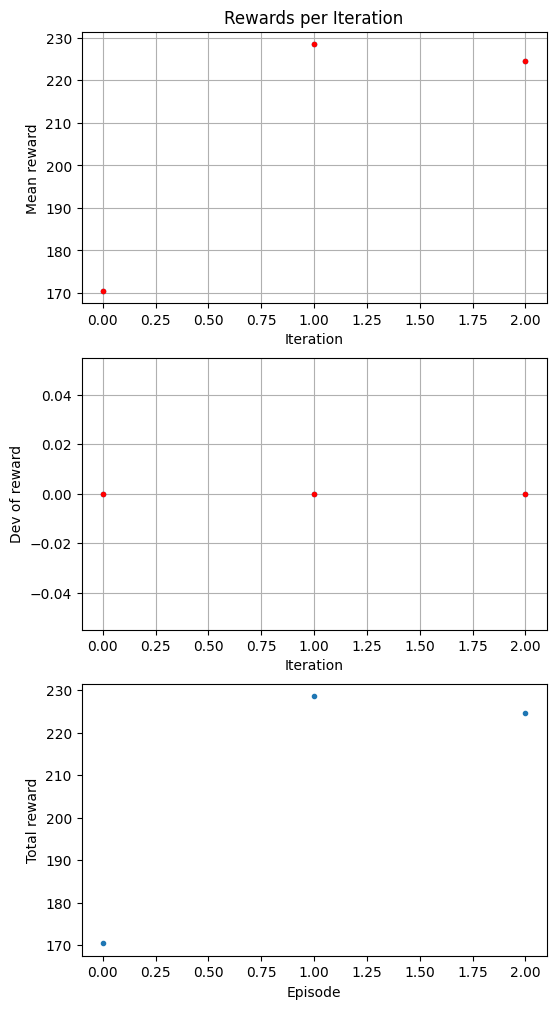

In [65]:
REWARD_THRESHOLD = 0

# reward graph per episode
min_episodes = np.min(df['episode'])
max_episodes = np.max(df['episode'])
print('Number of episodes = ', max_episodes)

total_reward_per_episode = list()
    
for epi in np.arange(min_episodes, max_episodes+1,1):
    df_slice = df[df['episode'] == epi]
    total_reward_per_episode.append(np.sum(df_slice['reward']))

average_reward_per_iteration = list()
deviation_reward_per_iteration = list()

buffer_rew = list()
for val in total_reward_per_episode:
    buffer_rew.append(val)

    if len(buffer_rew) == EPISODE_PER_ITER:
        average_reward_per_iteration.append(np.mean(buffer_rew))
        deviation_reward_per_iteration.append(np.std(buffer_rew))
        # reset
        buffer_rew = list()


fig = plt.figure(figsize=(6, 12))
ax = fig.add_subplot(311)
ax.plot(np.arange(len(average_reward_per_iteration)), average_reward_per_iteration, '.')
ax.set_title('Rewards per Iteration')
ax.set_ylabel('Mean reward')
ax.set_xlabel('Iteration')

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD :
        ax.plot(rr, average_reward_per_iteration[rr], 'r.')

plt.grid(True)

ax = fig.add_subplot(312)
ax.plot(np.arange(len(deviation_reward_per_iteration)), deviation_reward_per_iteration, '.')

ax.set_ylabel('Dev of reward')
ax.set_xlabel('Iteration')
plt.grid(True)

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD:
        ax.plot(rr, deviation_reward_per_iteration[rr], 'r.')


ax = fig.add_subplot(313)
ax.plot(np.arange(len(total_reward_per_episode)), total_reward_per_episode, '.')
ax.set_ylabel('Total reward')
ax.set_xlabel('Episode')

## Analyze training/evaluation metrics with progress and reward function

This graph gives you an idea whether your model has convergered or more training is required. If you see the curve trending upwards then more training time would help the agent to get better rewards

In [66]:
if is_training:
    METRIC_PATH = glob.glob("./intermediate_checkpoint/{}/metrics/training/*.json".format(ModelUuid))[0]
else:
    METRIC_PATH = glob.glob("./intermediate_checkpoint/{}/metrics/evaluation/*.json".format(ModelUuid))[0]
    
with open(METRIC_PATH, "r") as fp:
    data = json.loads(fp.read())
    metric_data = data['metrics']
    df_metrics = pd.DataFrame(metric_data)

if is_training:
    df_metrics = df_metrics[df_metrics['phase'] == "training"]

In [67]:
df_metrics

,completion_percentage,metric_time,start_time,elapsed_time_in_milliseconds,episode_status,crash_count,immobilized_count,off_track_count,reversed_count,reset_count,trial
0,100,65939,6246,59693,Lap complete,0,0,12,0,12,1
1,100,130749,66113,64636,Lap complete,0,0,11,1,12,2
2,100,193258,130887,62371,Lap complete,0,0,11,1,12,3


Mean percentage: 100.0


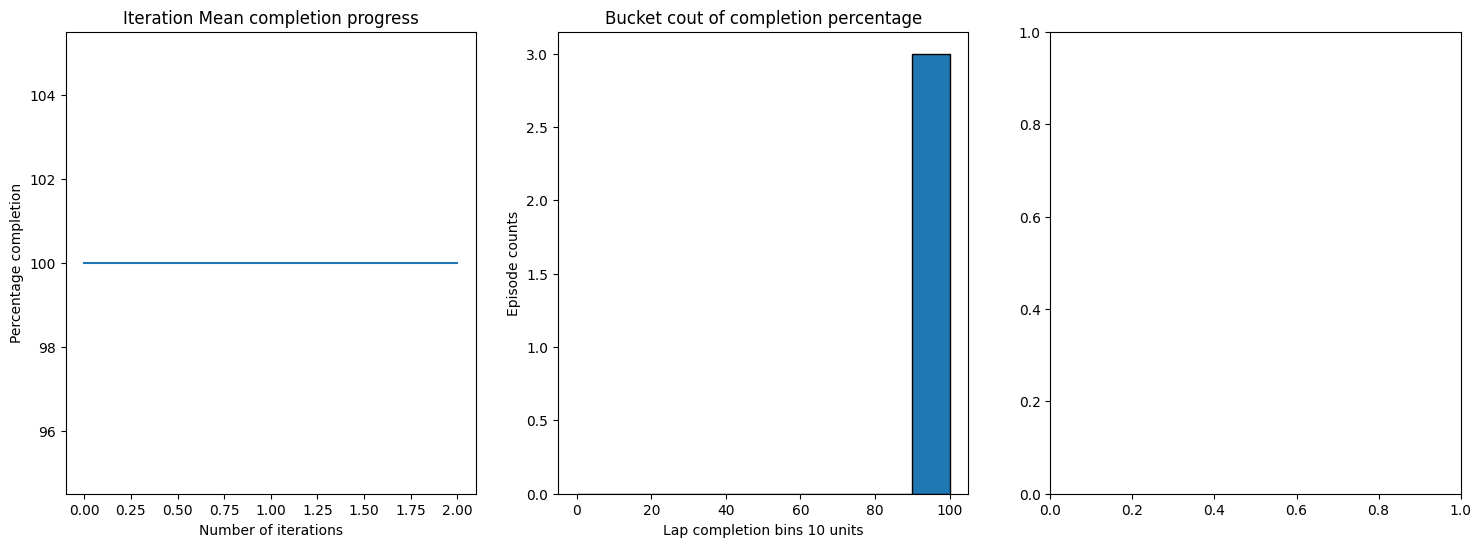

In [68]:
bins= [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

df_metrics = df_metrics.sort_values(by="metric_time")
print('Mean percentage: {}'.format(df_metrics.completion_percentage.mean()))

completion_percentage_np = np.array(df_metrics.completion_percentage)
episode_progress_buckets = np.split(completion_percentage_np[:EPISODE_PER_ITER*(len(completion_percentage_np)//EPISODE_PER_ITER)],
                                    len(completion_percentage_np)//EPISODE_PER_ITER)
episode_progress_mean = np.mean(episode_progress_buckets, axis=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
# Line graph showing the mean iteration of completion progress
ax1.plot(episode_progress_mean)
ax1.title.set_text('Iteration Mean completion progress')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Percentage completion')

# Bar chart to show completion_percentage with bucketing of 10% bar chart
ax2.hist(df_metrics.completion_percentage, bins=bins, edgecolor="k")
ax2.title.set_text('Bucket cout of completion percentage')
ax2.set_xlabel('Lap completion bins 10 units')
ax2.set_ylabel('Episode counts')

# Line graph showing the mean iteration of reward mean
if is_training:
    reward_score_np = np.array(df_metrics.reward_score)
    episode_reward_buckets = np.split(reward_score_np[:EPISODE_PER_ITER*(len(reward_score_np)//EPISODE_PER_ITER)],
                                                      len(reward_score_np)//EPISODE_PER_ITER)
    episode_reward_mean = np.mean(episode_reward_buckets, axis=1)
    ax3.plot(episode_reward_mean)
    plt.title("Metric analysis - Reward/percentage vs number of iterations")
    ax3.title.set_text('Iteration Mean reward')
    ax3.set_xlabel('Number of iterations')
    ax3.set_ylabel('Reward score')
    plt.show()


## Analyze the reward distribution for your reward function

In [69]:
print("Min x-axis {}; Max x-axis {}".format(np.min(df['x']), np.max(df['x'])))
print("Min y-axis {}; Max y-axis {}".format(np.min(df['y']), np.max(df['y'])))

Min x-axis -12.183690650035617; Max x-axis 10.861862496910666
Min y-axis -4.450021157911296; Max y-axis 5.683499089946031


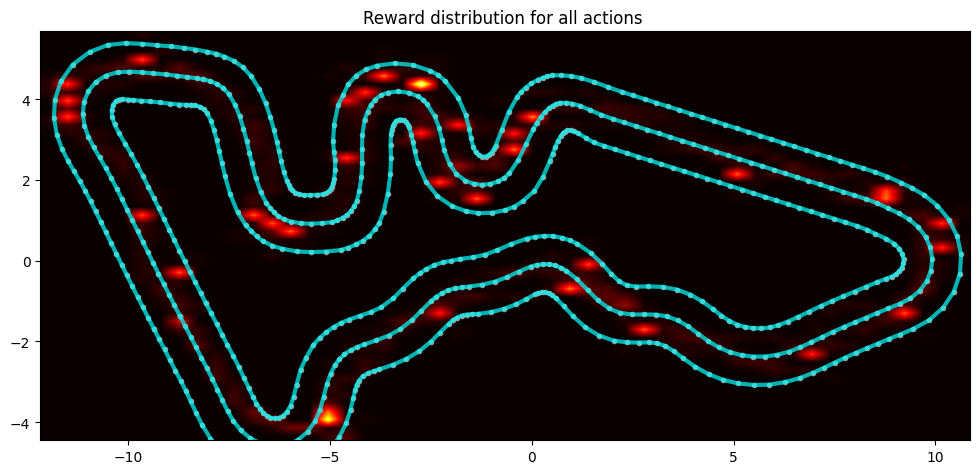

In [71]:
track,extent = plot_track(df, track_size=(12, 12), x_offset=0, y_offset=0)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', extent=extent, interpolation='bilinear', origin="lower") 

### Plot a particular iteration


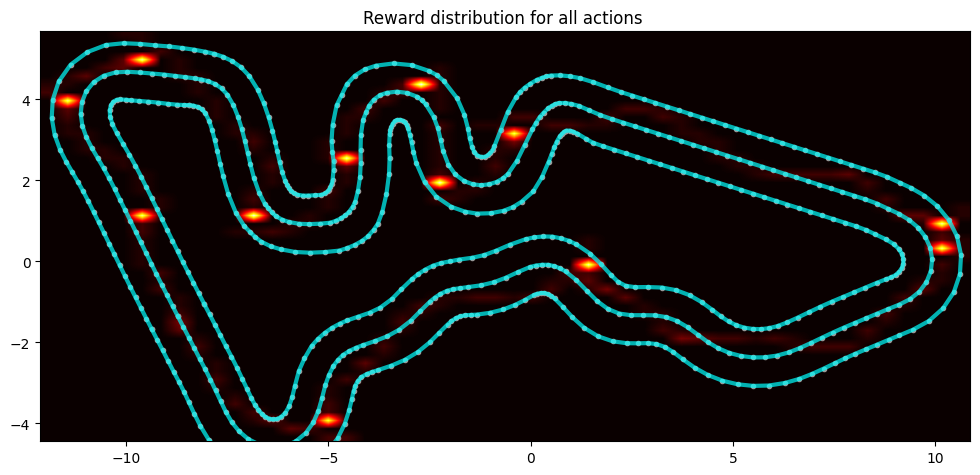

In [72]:
iteration_id = 1
track,extent = plot_track(df[df['iteration'] == iteration_id], track_size=(12, 12), x_offset=0, y_offset=0)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', extent=extent, interpolation='bilinear', origin="lower") 

### Path taken for top reward iterations

NOTE: in a single episode, the car can go around multiple laps, the episode is terminated when car completes 1000 steps

The top 3 highest reward episodes are [1, 2, 0]


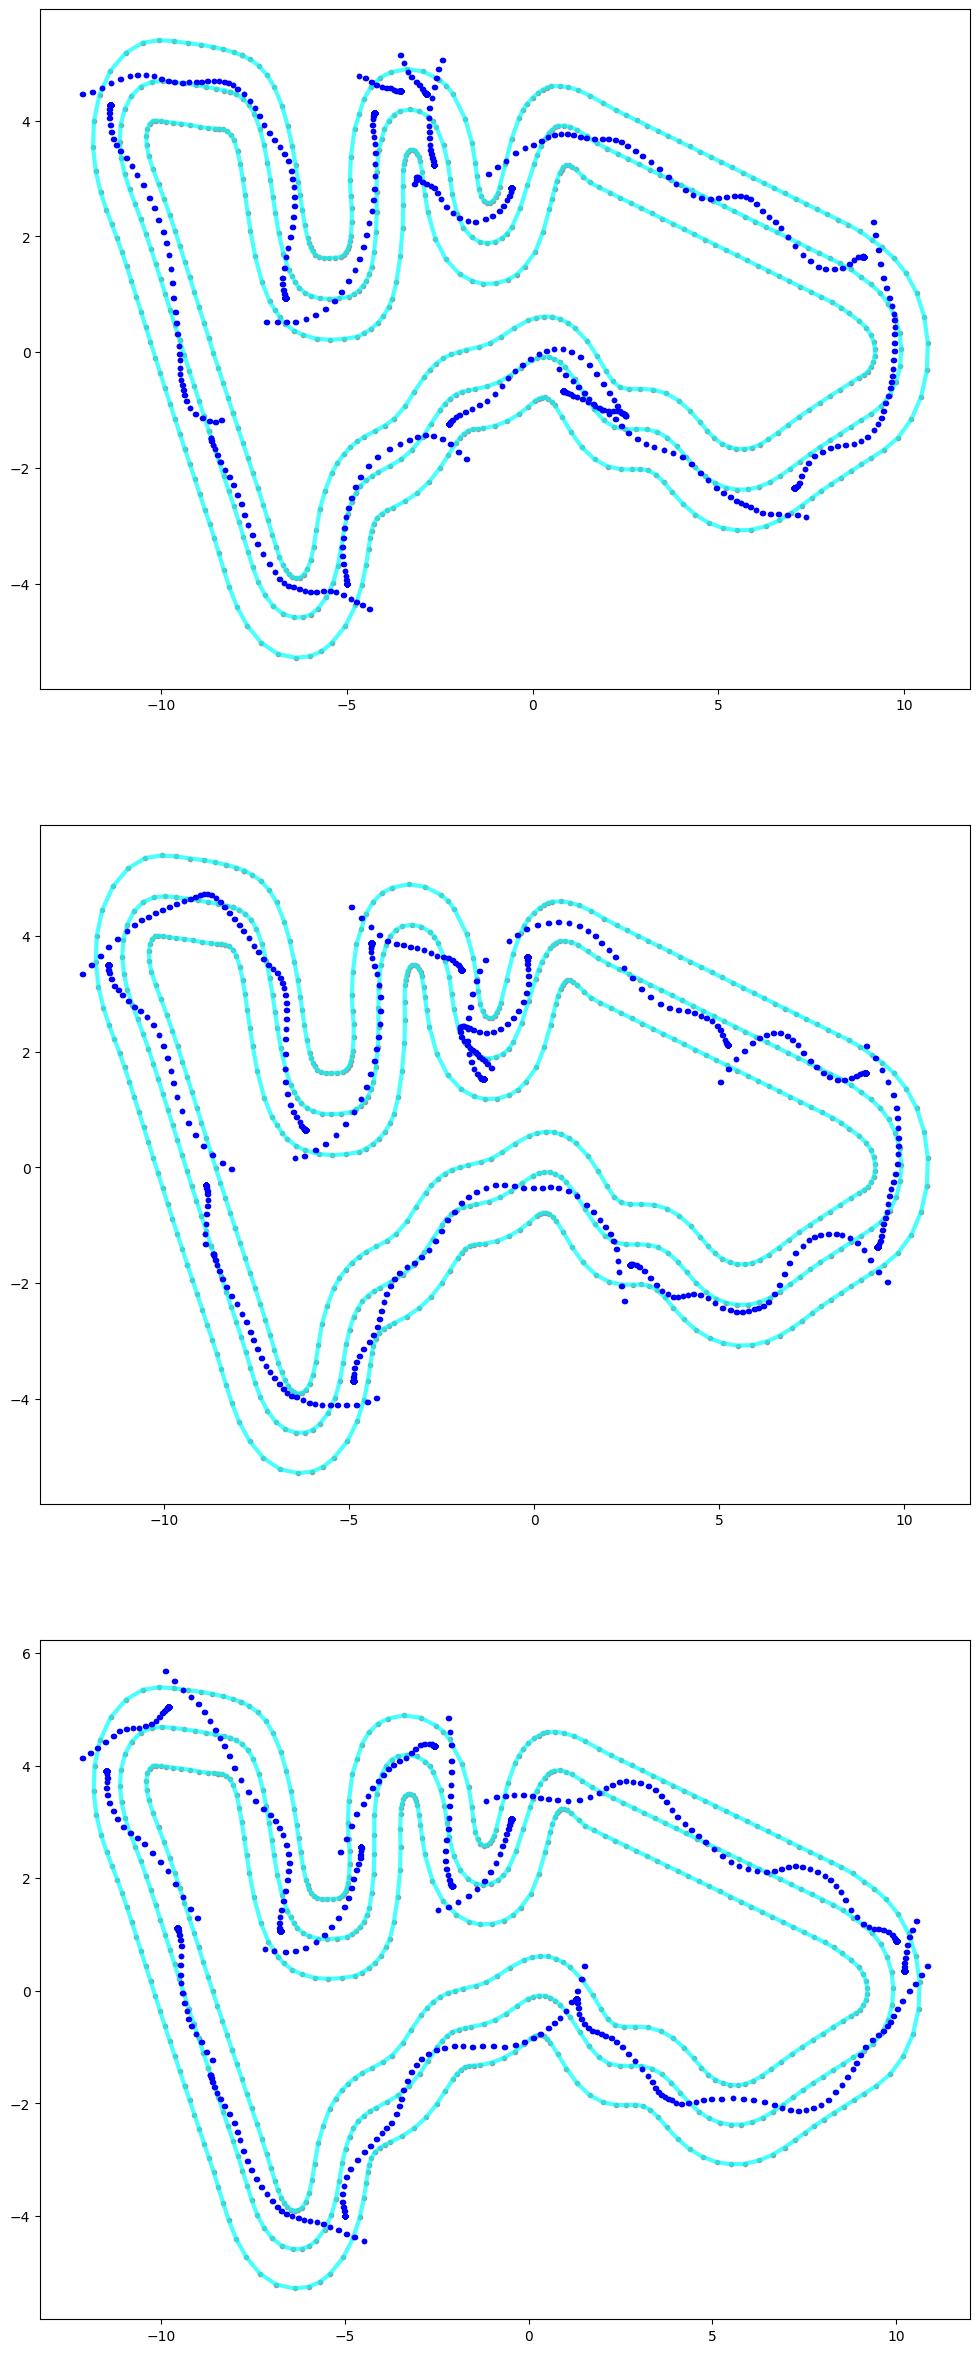

In [73]:
action_map, episode_map, sorted_idx = episode_parser(df)    
fig = plot_top_laps(sorted_idx[:], 3)
print("The top 3 highest reward episodes are {}".format(sorted_idx[:3]))

### Path taken in a particular episode

In [74]:
## Evaluation RUN
def plot_episode_run(df, E):
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(211)
    print_border(ax, center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')

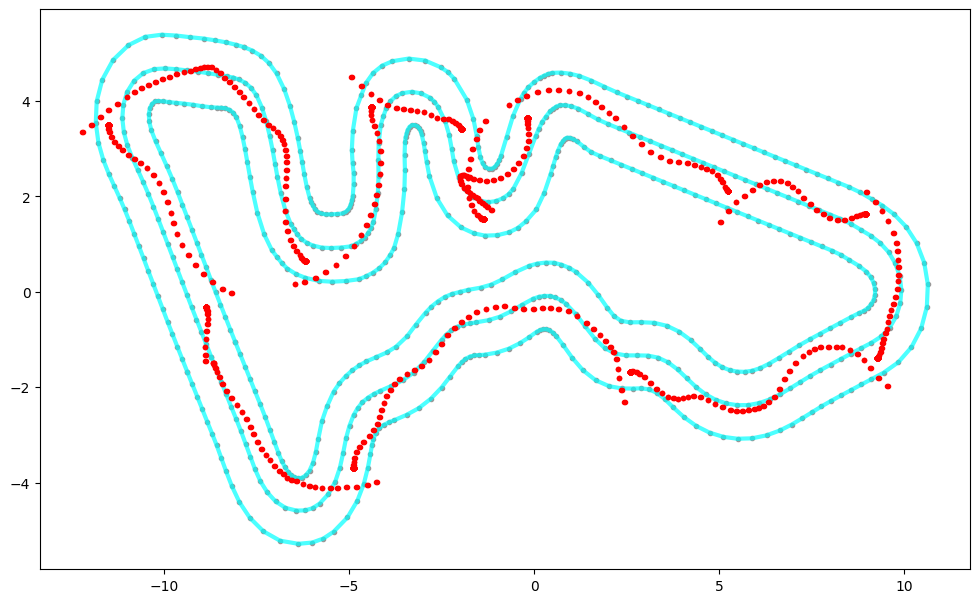

In [75]:
plot_episode_run(df, E=2) # arbitrary episode

### Path taken in a particular Iteration

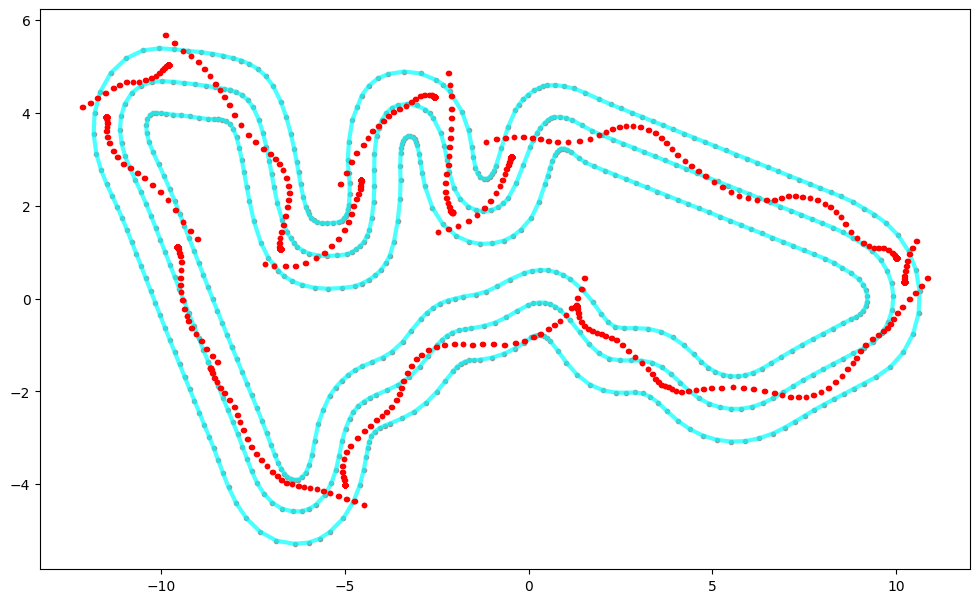

In [76]:
iteration_id = 1

for i in range((iteration_id-1)*EPISODE_PER_ITER, (iteration_id)*EPISODE_PER_ITER):
    plot_episode_run(df, E=i)

## Action breakdown per iteration and historgram for action distribution for each of the turns - reinvent track

This plot is useful to understand the actions that the model takes for any given iteration.

Say you want the car to go at higher speeds on the straight line. This will give you an idea what actions the car is taking along those segments

In [77]:
# The actions plotted on the tracks may become noise. Use this to clip the low reward values action.
# Anything with reward < 0.8 is clipped. This is based on the reward function you trained on.

REWARD_THRESHOLD = 0.8

In [78]:
# Track Segment Labels
action_names = []
for action in model_metadata['action_space']:
    action_names.append("ST"+str(action['steering_angle'])+" SP"+"%.2f"%action["speed"])
action_names

['ST-24.0 SP1.38',
 'ST-24.0 SP2.12',
 'ST-24.0 SP2.88',
 'ST-24.0 SP3.62',
 'ST-12.0 SP1.38',
 'ST-12.0 SP2.12',
 'ST-12.0 SP2.88',
 'ST-12.0 SP3.62',
 'ST0.0 SP1.38',
 'ST0.0 SP2.12',
 'ST0.0 SP2.88',
 'ST0.0 SP3.62',
 'ST12.0 SP1.38',
 'ST12.0 SP2.12',
 'ST12.0 SP2.88',
 'ST12.0 SP3.62',
 'ST24.0 SP1.38',
 'ST24.0 SP2.12',
 'ST24.0 SP2.88',
 'ST24.0 SP3.62']

**Define track labels**

This hash defines the labels for track segments on various tracks. Analyzing new tracks will require adding a new entry to this hash.

In [81]:
track_segments_hash = { "reinvent_base": [(0, 'straightaway'),
                                          (20, 'hairpin'),
                                          (46, 'slight right'),
                                          (61, 'left'),
                                          (76, 'slight left'),
                                          (90, 'straightaway'),
                                          (103, 'left'),
                                          (113, 'straightaway')                                         
                                          ],
                       "reInvent2019_track": [(0, 'left'),
                                              (18, 'sharp right'),
                                              (33, 'gentle left'),
                                              (82, 'left'),
                                              (93, 'slight left'),
                                              (107, 'left'),
                                              (117, 'right'),
                                              (137, 'left')
                                             ],
                       "arctic_open": [(0, 'straightaway'),
                                       (24,'left'),
                                       (36,'right'),
                                       (52,'left'),
                                       (67,'hairpin left'),
                                       (84,'right'),
                                       (98,'slight left'),
                                       (107,'straightaway'),
                                       (125,'slight left'),
                                       (134,'straightaway'),
                                       (156,'hairpin left')            
                       ],
                       "caecer_loop": [(0, 'straightaway'),
                                       (14,'slight left'),
                                       (34,'straightaway'),
                                       (42,'hairpin left'),
                                       (70,'straightaway'),
                                       (80,'sharp left'),
                                       (93,'straightaway'),
                                       (103,'slight left'),
                                       (115,'straightaway')            
                       ],
                       "red_star_open":[(0,'straightaway'),
                                        (29,'left'),
                                        (41,'straightaway'),
                                        (67,'hairpin left'),
                                        (78,'straightaway'),
                                        (94,'s-turn right'),
                                        (107,'s-turn left'),
                                        (119,'s-turn right'),
                                        (130,'s-turn left'),
                                        (140,'straightaway'),
                                        (155,'sharp left'),
                                        (163,'straightaway')                           
                       ]
}
trackname

'Austin'

Track name 'Austin' not found in track_segments_hash. Using default value.
Number of steps in iteration= 618


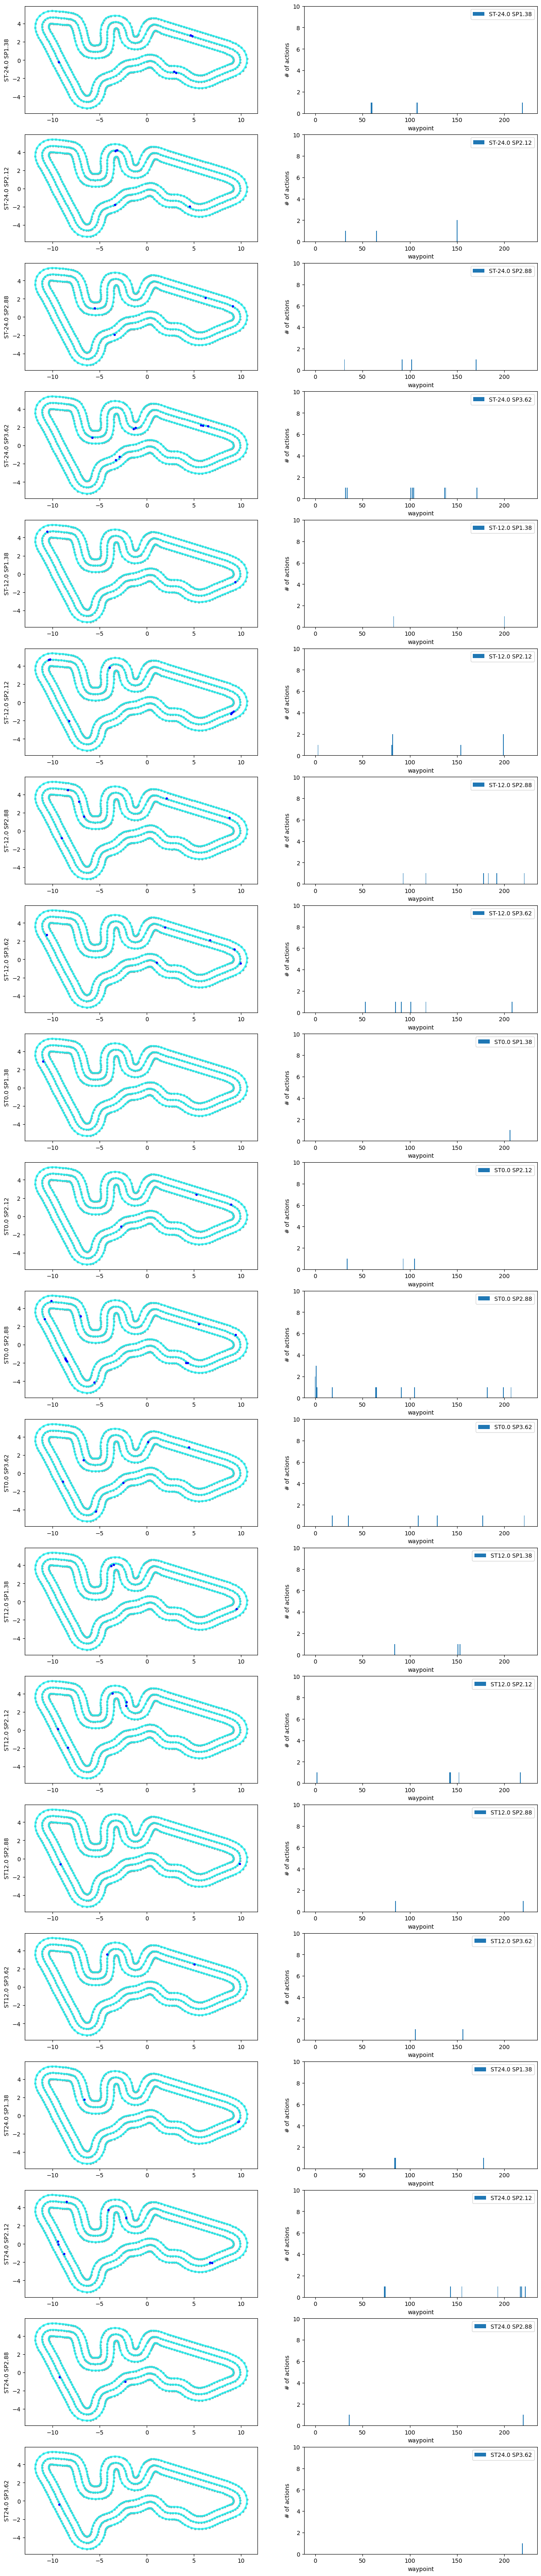

In [84]:
fig = plt.figure(figsize=(16, 4*len(action_names)))
iterations_downselect = [iteration_id] ## Lets pick the iteratons with the highest rewards

y_limit = 10
default_track_segments = []  # or any appropriate default value
try:
    track_segments = track_segments_hash[trackname]
except KeyError:
    print(f"Track name '{trackname}' not found in track_segments_hash. Using default value.")
    track_segments = default_track_segments

# Continue with the rest of the code
segment_x = []
segment_y = []
segment_x=[]
segment_y=[]
segment_xerr_l=[]
segment_xerr_r=[]
segment_yerr_n=[]
segment_yerr_s=[]
i=0
while i<len(track_segments):
    segment_x.append(track_segments[i][0])
    segment_y.append(0)
    segment_xerr_l.append(0)
    if i>=len(track_segments)-1:
        segment_xerr_r.append(len(waypoints)-track_segments[i][0])
    else:
        segment_xerr_r.append(track_segments[i+1][0]-track_segments[i][0])
    segment_yerr_n.append(0)
    segment_yerr_s.append(y_limit)
    i+=2

segment_x = np.array(segment_x)
segment_y = np.array(segment_y)
segment_xerr = np.array([segment_xerr_l,segment_xerr_r])
segment_yerr = np.array([segment_yerr_n,segment_yerr_s])

#segment_x = np.array(vert_lines)
#segment_y = np.array([0]*len(vert_lines))
#segment_xerr = np.array([[0]*len(vert_lines),[1]*len(vert_lines)])
#segment_yerr = np.array([[0]*len(vert_lines), [150]*len(vert_lines)])

wpts_array = center_line 
text_y=[.66*y_limit,.5*y_limit,.33*y_limit]
    
for iter_num in iterations_downselect:

    # Slice the data frame to get all episodes in that iteration
    df_iter = df[(iter_num == df['iteration'])]
    n_steps_in_iter = len(df_iter)
    print('Number of steps in iteration=', n_steps_in_iter)

    # Reward function threshold
    th = REWARD_THRESHOLD
    for idx in range(len(action_names)):
        ax = fig.add_subplot(len(action_names), 2, 2*idx+1)
        print_border(ax, center_line, inner_border, outer_border) 
            
        df_slice = df_iter[df_iter['reward'] >= th]
        df_slice = df_slice[df_slice['action'] == idx]

        ax.plot(df_slice['x'], df_slice['y'], 'b.')

        for idWp in track_segments:
            ax.text(wpts_array[idWp[0]][0], wpts_array[idWp[0]][1], str(idWp[0]), bbox=dict(facecolor='red', alpha=0.5))

        #ax.set_title(str(log_name_id) + '-' + str(iter_num) + ' w rew >= '+str(th))
        ax.set_ylabel(action_names[idx])

        # calculate action way point distribution
        action_waypoint_distribution = list()
        for idWp in range(len(wpts_array)):
            action_waypoint_distribution.append(len(df_slice[df_slice['closest_waypoint'] == idWp]))

        ax = fig.add_subplot(len(action_names), 2, 2 * idx + 2)

        # Call function to create error boxes
        _ = make_error_boxes(ax, segment_x, segment_y, segment_xerr, segment_yerr)


        i=0
        for tt in range(len(track_segments)):
            ax.text(track_segments[tt][0], text_y[i], track_segments[tt][1])
            i = (i+1)%len(text_y)

        ax.bar(np.arange(len(wpts_array)), action_waypoint_distribution)
        ax.set_xlabel('waypoint')
        ax.set_ylabel('# of actions')
        ax.legend([action_names[idx]])
        ax.set_ylim((0, y_limit))

Lets analyze the actions chosen for each situation. Does this model choose to steer or go straight on straightaways? Does it choose to speed up or slow down? Are entire portions of the action space ignored, suggesting a mismatch between the action space at the reward function?

## Simulation Image Analysis - Probability distribution on decisions (actions)

is the model making decisions that are "too close" or is it confident for the laps it finishes. if the top and second best decisions are far apart, the model must likely be making more confident decisions 

In [85]:
import glob
img_path = "simulation_episode/"
all_files = sorted(glob.glob(img_path + '/*.png'))

#### Download all the checkpoints (provided as an example).  
We recommend downloading only the ones you are interested in


In [96]:
import tensorflow.compat.v1 as tf
from tensorflow.python.platform import gfile
from PIL import Image

tf.disable_v2_behavior()

GRAPH_PB_PATH = 'intermediate_checkpoint/'

def load_session(pb_path):
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, 
                                    log_device_placement=True))
    print("load graph:", pb_path)
    with gfile.FastGFile(pb_path,'rb') as f:
        graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    graph_nodes=[n for n in graph_def.node]
    names = []
    for t in graph_nodes:
        names.append(t.name)
    
    # For front cameras/stereo camera use the below
    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/{}/{}:0'.format(sensor, sensor))
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    
    return sess, x, y

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [97]:
model_inference = []
iterations = [7,8,9]
models_file_path = glob.glob("{}{}/model/model_*.pb".format(GRAPH_PB_PATH, ModelUuid))

for model_file in models_file_path:
    model, obs, model_out = load_session(model_file)
    arr = []
    for f in all_files[:]:
        img = Image.open(f)
        img_arr = np.array(img)
        img_arr = rgb2gray(img_arr)
        img_arr = np.expand_dims(img_arr, axis=2)
        current_state = {"observation": img_arr} #(1, 120, 160, 1)
        y_output = model.run(model_out, feed_dict={obs:[img_arr]})[0]
        arr.append (y_output)
        
    model_inference.append(arr)
    model.close()
    tf.reset_default_graph()

Device mapping: no known devices.
load graph: intermediate_checkpoint/5ee2d371-f26a-4cb5-8a82-9a43997088e7/model/model_9.pb
Device mapping: no known devices.
load graph: intermediate_checkpoint/5ee2d371-f26a-4cb5-8a82-9a43997088e7/model/model_39.pb
Device mapping: no known devices.
load graph: intermediate_checkpoint/5ee2d371-f26a-4cb5-8a82-9a43997088e7/model/model_40.pb
Device mapping: no known devices.


I0000 00:00:1727273393.933588   16875 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-25 22:09:53.933755: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
I0000 00:00:1727273394.008072   16875 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-0

load graph: intermediate_checkpoint/5ee2d371-f26a-4cb5-8a82-9a43997088e7/model/model_38.pb


Inference for model: intermediate_checkpoint/5ee2d371-f26a-4cb5-8a82-9a43997088e7/model/model_9.pb


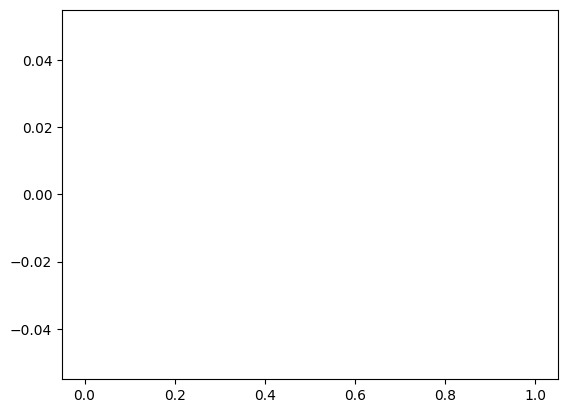

Inference for model: intermediate_checkpoint/5ee2d371-f26a-4cb5-8a82-9a43997088e7/model/model_39.pb


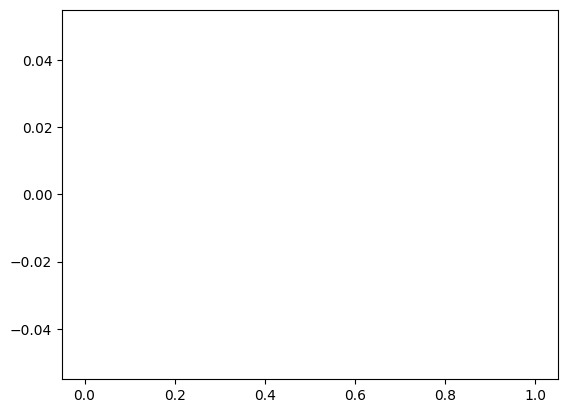

Inference for model: intermediate_checkpoint/5ee2d371-f26a-4cb5-8a82-9a43997088e7/model/model_40.pb


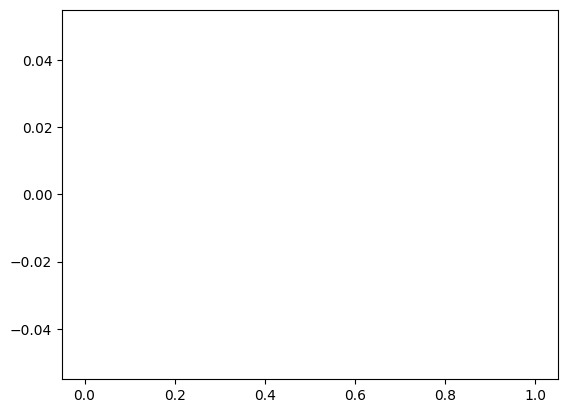

Inference for model: intermediate_checkpoint/5ee2d371-f26a-4cb5-8a82-9a43997088e7/model/model_38.pb


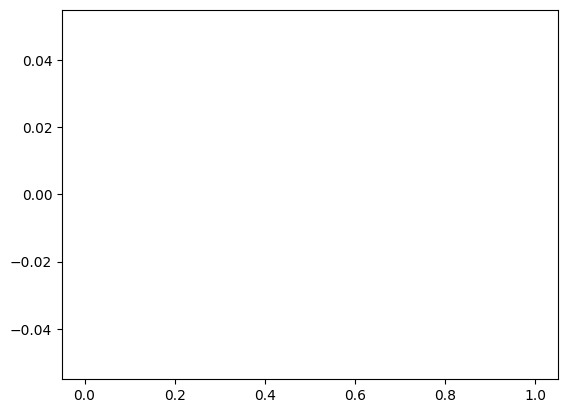

In [98]:
prob_diff = []

for model, model_file in zip(model_inference, models_file_path):
    print("Inference for model: {}".format(model_file))
    for mi in model:
        max1, max2 = mi.argsort()[-2:][::-1]
        prob_diff.append(mi[max1] - mi[max2])
    plt.hist(prob_diff)
    plt.show()

The model which appears to have a better seperation in probabability will work better in sim2real experiments

# Model CSV Analysis


Download the model from the console AWS DeepRacer > Reinforcement learning > $Training Job Name$ > Download Model


In [99]:
fname = './intermediate_checkpoint/{}/model-artifacts/worker_0.multi_agent_graph.main_level.main_level.agent_0.csv'.format(ModelUuid)
df_csv = pd.read_csv(fname)

In [100]:
df_csv.columns

Index(['Episode #', 'Training Iter', 'Epoch', 'In Heatup', 'ER #Transitions',
       'ER #Episodes', 'Episode Length', 'Total steps', 'Epsilon',
       'Shaped Training Reward', 'Training Reward', 'Update Target Network',
       'Wall-Clock Time', 'Evaluation Reward', 'Shaped Evaluation Reward',
       'Success Rate', 'Inverse Propensity Score', 'Direct Method Reward',
       'Doubly Robust', 'Weighted Importance Sampling',
       'Sequential Doubly Robust', 'Loss/Mean', 'Loss/Stdev', 'Loss/Max',
       'Loss/Min', 'Learning Rate/Mean', 'Learning Rate/Stdev',
       'Learning Rate/Max', 'Learning Rate/Min', 'Grads (unclipped)/Mean',
       'Grads (unclipped)/Stdev', 'Grads (unclipped)/Max',
       'Grads (unclipped)/Min', 'Discounted Return/Mean',
       'Discounted Return/Stdev', 'Discounted Return/Max',
       'Discounted Return/Min', 'Entropy/Mean', 'Entropy/Stdev', 'Entropy/Max',
       'Entropy/Min', 'Advantages/Mean', 'Advantages/Stdev', 'Advantages/Max',
       'Advantages/Min',

<Axes: title={'center': 'Training'}, xlabel='Training Iter'>

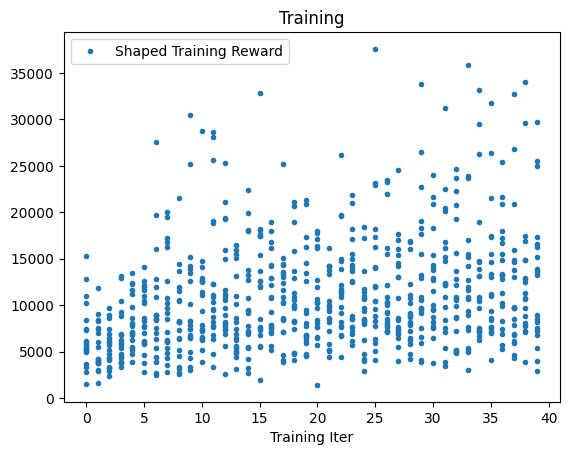

In [101]:
title = "Training"
df_csv.plot(x='Training Iter', y='Shaped Training Reward', style='.', 
        title=title)

<Axes: >

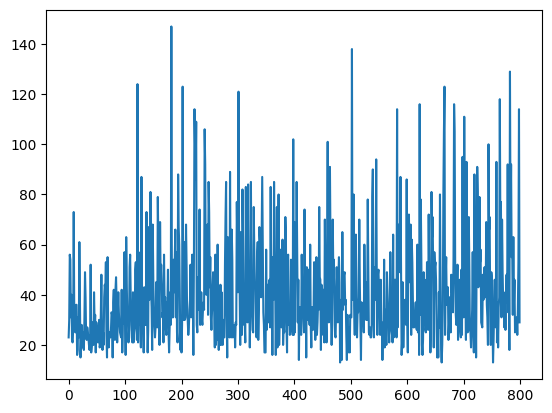

In [102]:
df_csv['Episode Length'].plot()

## What is the model looking at?

Gradcam: visual heatmap of where the model is looking to make its decisions. based on https://arxiv.org/pdf/1610.02391.pdf

In [107]:
import cv2

def visualize_gradcam_discrete_ppo(sess, rgb_img, category_index=0, num_of_actions=5):
    '''
    @inp: model session, RGB Image - np array, action_index, total number of actions 
    @return: overlayed heatmap
    '''
    
    img_arr = np.array(img)
    img_arr = rgb2gray(img_arr)
    img_arr = np.expand_dims(img_arr, axis=2)
    
    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/{}/{}:0'.format(sensor, sensor))
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    feed_dict = {x:[img_arr]}

    #Get he policy head for clipped ppo in coach
    model_out_layer = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    loss = tf.multiply(model_out_layer, tf.one_hot([category_index], num_of_actions))
    reduced_loss = tf.reduce_sum(loss[0])
    
    # For front cameras use the below
    conv_output = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/{}/Conv2d_4/Conv2D:0'.format(sensor))
    
    grads = tf.gradients(reduced_loss, conv_output)[0]
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.sum(weights * output, axis=3)

    ##im_h, im_w = 120, 160##
    im_h, im_w = rgb_img.shape[:2]

    cam = cams[0] #img 0
    image = np.uint8(rgb_img[:, :, ::-1] * 255.0) # RGB -> BGR
    cam = cv2.resize(cam, (im_w, im_h)) # zoom heatmap
    cam = np.maximum(cam, 0) # relu clip
    heatmap = cam / np.max(cam) # normalize
    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET) # grayscale to color
    cam = np.float32(cam) + np.float32(image) # overlay heatmap
    cam = 255 * cam / (np.max(cam) + 1E-5) ##  Add expsilon for stability
    cam = np.uint8(cam)[:, :, ::-1] # to RGB

    return cam

In [111]:
import glob
img_path = "simulation_episode/"
all_files = sorted(glob.glob(img_path + '/*.png'))

In [112]:
import os
import glob
import tensorflow.compat.v1 as tf
from tensorflow.python.platform import gfile
from PIL import Image
import numpy as np

# Suppress TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress all logs except errors

tf.disable_v2_behavior()

GRAPH_PB_PATH = 'intermediate_checkpoint/'
ModelUuid = '5ee2d371-f26a-4cb5-8a82-9a43997088e7'
all_files = glob.glob("path_to_images/*.png")  # Update with the correct path to your images

def load_session(pb_path):
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, 
                                    log_device_placement=True))
    print("load graph:", pb_path)
    with gfile.FastGFile(pb_path,'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        sess.graph.as_default()
        tf.import_graph_def(graph_def, name='')
    
    # For front cameras/stereo camera use the below
    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/SECTOR_LIDAR/SECTOR_LIDAR:0')
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    
    return sess, x, y

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def visualize_gradcam_discrete_ppo(model, img, category_index, num_of_actions):
    # Placeholder function for Grad-CAM visualization
    # Replace with actual implementation
    return np.random.rand(120, 160)

model_path = models_file_path[0]  # Change this to your model 'pb' frozen graph file
model, obs, model_out = load_session(model_path)
heatmaps = []

# Just need to match up the shape of the neural network
if 'action_space_type' in model_metadata and model_metadata['action_space_type'] == 'continuous':
    num_of_actions = 2
else:
    num_of_actions = len(action_names)

for f in all_files[:5]:
    img = np.array(Image.open(f))
    img_arr = rgb2gray(img)
    img_arr = np.expand_dims(img_arr, axis=2)
    
    # Adjust input data to match expected shape (1, 8)
    img_arr_resized = np.resize(img_arr, (1, 8))
    
    heatmap = visualize_gradcam_discrete_ppo(model, img_arr_resized, category_index=0, num_of_actions=num_of_actions)
    heatmaps.append(heatmap)

tf.reset_default_graph()

Device mapping: no known devices.
load graph: intermediate_checkpoint/5ee2d371-f26a-4cb5-8a82-9a43997088e7/model/model_9.pb


I0000 00:00:1727273567.077084   16875 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-25 22:12:47.077323: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [113]:
for i in range(len(heatmaps)):
    plt.imshow(heatmaps[i])
    plt.show()